In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import interact, fixed
import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from src.preprocessing import parse_data, split_train_test
from src.training import trainer
from src.models import LSTM, LSTMAtt, CNN
from src.evaluation import eval_model, get_saliencies, vizualize_saliency, test_attack
from src.plotting import plot_saliency_eps, plot_saliency_heatmap

# Project tasks

# 1. Choose a dataset and train LSTM, LSTMAtt, CNN models.

We have chosen `ItalyPowerDemand` dataset form the provided [catalog](https://www.timeseriesclassification.com/description.php?Dataset=ItalyPowerDemand). 

This dataset consists of 67 time series of length 24, corresponding to hourly power demand. One time series if one day. The task is to destinguish between October to March (inclusive) from April to September.

## 1.1. Load data

In [3]:
df, labels = parse_data()

In [4]:
df.shape, labels.shape

(torch.Size([67, 24, 1]), torch.Size([67]))

In [5]:
df_train_features, df_train_labels, df_val_features, df_val_labels = split_train_test(df, labels)

In [6]:
print(df_train_features.shape, df_train_labels.shape, df_val_features.shape, df_val_labels.shape)

torch.Size([34, 24, 1]) torch.Size([34]) torch.Size([33, 24, 1]) torch.Size([33])


In [7]:
import torch
torch.unique(labels, return_counts=True)

(tensor([0, 1]), tensor([33, 34]))

In [8]:
torch.unique(df_train_labels, return_counts=True)

(tensor([0, 1]), tensor([13, 21]))

In [9]:
torch.unique(df_val_labels , return_counts=True)

(tensor([0, 1]), tensor([20, 13]))

## 1.2 Training

In [10]:
n_epochs = 500
tolerance = 100
freq_print = 10

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### 1.2.1. LSTM

In [12]:
lstm_model = LSTM(1, 10, 1, 2).to(device)

In [13]:
device

'cuda:0'

In [14]:
lstm_model = trainer(
    model=lstm_model,
    n_epochs=n_epochs,
    X_train=df_train_features,
    y_train=df_train_labels,
    X_val=df_val_features,
    y_val=df_val_labels,
    device=device,
    tolerance=tolerance,
    freq_print=freq_print,
)

Epoch = 9, 	Loss = 0.7059451341629028, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 19, 	Loss = 0.7102514505386353, 	Training_acc = 0.5476190476190477, 	Validation_acc = 0.5384615384615384
Epoch = 29, 	Loss = 0.6024326682090759, 	Training_acc = 0.5970695970695971, 	Validation_acc = 0.6230769230769231
Epoch = 39, 	Loss = 0.6195307970046997, 	Training_acc = 0.6446886446886447, 	Validation_acc = 0.6115384615384616
Epoch = 49, 	Loss = 0.6376277804374695, 	Training_acc = 0.6446886446886447, 	Validation_acc = 0.6365384615384615
Epoch = 59, 	Loss = 0.607039749622345, 	Training_acc = 0.6446886446886447, 	Validation_acc = 0.6865384615384615
Epoch = 69, 	Loss = 0.5685370564460754, 	Training_acc = 0.6446886446886447, 	Validation_acc = 0.7115384615384616
Epoch = 79, 	Loss = 0.5516713857650757, 	Training_acc = 0.7454212454212454, 	Validation_acc = 0.7365384615384616
Epoch = 89, 	Loss = 0.5204773545265198, 	Training_acc = 0.8608058608058609, 	Validation_acc = 0.9
Epoch = 99, 	Loss = 0.57639670

### 1.2.2. LSTMAtt

In [15]:
lstmatt_model = LSTMAtt(1, 30, 1, 2).to(device)

In [16]:
lstmatt_model = trainer(
    model=lstmatt_model,
    n_epochs=n_epochs,
    X_train=df_train_features,
    y_train=df_train_labels,
    X_val=df_val_features,
    y_val=df_val_labels,
    device=device,
    tolerance=tolerance,
    freq_print=freq_print,
)

Epoch = 9, 	Loss = 0.6193745732307434, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 19, 	Loss = 0.6803463697433472, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 29, 	Loss = 0.680104672908783, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 39, 	Loss = 0.6098487377166748, 	Training_acc = 0.5, 	Validation_acc = 0.5
Epoch = 49, 	Loss = 0.5981389284133911, 	Training_acc = 0.5128205128205128, 	Validation_acc = 0.6057692307692308
Epoch = 59, 	Loss = 0.6060721278190613, 	Training_acc = 0.5879120879120879, 	Validation_acc = 0.6076923076923078
Epoch = 69, 	Loss = 0.5318315029144287, 	Training_acc = 0.5183150183150182, 	Validation_acc = 0.47692307692307695
Epoch = 79, 	Loss = 0.5131038427352905, 	Training_acc = 0.5421245421245421, 	Validation_acc = 0.5788461538461538
Epoch = 89, 	Loss = 0.46580150723457336, 	Training_acc = 0.5567765567765568, 	Validation_acc = 0.5269230769230769
Epoch = 99, 	Loss = 0.5033902525901794, 	Training_acc = 0.5952380952380952, 	Validation_acc = 0.6538461

### 1.2.3. CNN

In [17]:
df_train_features_cnn = df_train_features.transpose(1, 2)
df_val_features_cnn = df_val_features.transpose(1, 2)

In [18]:
cnn_model = CNN(2).to(device)

In [19]:
cnn_model = trainer(
    model=cnn_model,
    n_epochs=n_epochs,
    X_train=df_train_features,
    y_train=df_train_labels,
    X_val=df_val_features,
    y_val=df_val_labels,
    device=device,
    tolerance=tolerance,
    freq_print=freq_print,
)

Epoch = 9, 	Loss = 0.6430490016937256, 	Training_acc = 0.5, 	Validation_acc = 0.5


/home/alex/anaconda3/envs/impdirs/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch = 19, 	Loss = 0.6272711753845215, 	Training_acc = 0.5238095238095238, 	Validation_acc = 0.5384615384615384
Epoch = 29, 	Loss = 0.5977023839950562, 	Training_acc = 0.9047619047619048, 	Validation_acc = 0.7692307692307692
Epoch = 39, 	Loss = 0.5951899290084839, 	Training_acc = 0.9761904761904762, 	Validation_acc = 0.9615384615384616
Epoch = 49, 	Loss = 0.5886296033859253, 	Training_acc = 0.9761904761904762, 	Validation_acc = 0.9615384615384616
Epoch = 59, 	Loss = 0.5163890719413757, 	Training_acc = 0.9761904761904762, 	Validation_acc = 0.9615384615384616
Epoch = 69, 	Loss = 0.4917092025279999, 	Training_acc = 0.9761904761904762, 	Validation_acc = 0.9615384615384616
Epoch = 79, 	Loss = 0.5143230557441711, 	Training_acc = 0.9761904761904762, 	Validation_acc = 0.9615384615384616
Epoch = 89, 	Loss = 0.4842471480369568, 	Training_acc = 0.9761904761904762, 	Validation_acc = 0.9615384615384616
Epoch = 99, 	Loss = 0.45820972323417664, 	Training_acc = 0.9761904761904762, 	Validation_acc = 0

## 1.3. Evaluation

In [20]:
df_test, labels_test = parse_data(data_path='./data/ItalyPowerDemand_TEST.ts')

In [21]:
_ = eval_model(model_name="LSTM", model=lstm_model, X_test=df_test, y_test=labels_test, device=device)

LSTM test accuracy = 0.8903452105716487


In [22]:
_ = eval_model(model_name="LSTM with Attention", model=lstmatt_model, X_test=df_test, y_test=labels_test, device=device)

LSTM with Attention test accuracy = 0.7497733351466521


In [23]:
_ = eval_model(model_name="CNN", model=cnn_model, X_test=df_test, y_test=labels_test, device=device)

CNN test accuracy = 0.846984224126207


# 2. Saliency

Evaluate saliencies for the models. Calculate saliencies for each time series element and aggregate for all the data.

In [24]:
y_true = labels_test.detach().numpy()
idx_test_sorted = np.argsort(y_true)

In [25]:
((saliencies_lstm_0_, saliencies_lstm_1_), 
(saliencies_lstmatt_0_, saliencies_lstmatt_1_),
(saliencies_cnn_0_, saliencies_cnn_1_)) = *(get_saliencies(
    model=m, X=df_test, y=labels_test, device=device
) for m in (lstm_model, lstmatt_model, cnn_model)),

(saliencies_lstm, saliencies_lstmatt, saliencies_cnn) = \
    *(np.transpose(a, (0, 1, 2)).squeeze() for a in (
        saliencies_lstm_0_, saliencies_lstmatt_0_, saliencies_cnn_0_
)),

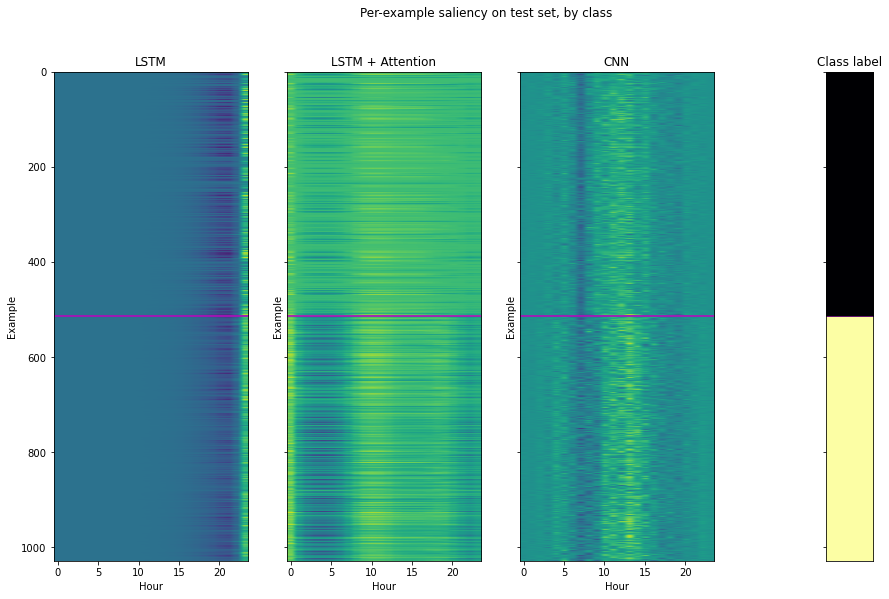

In [26]:
fig, ax = plt.subplots(1, 4, sharex=False, sharey=True, figsize=(16, 9), dpi=72)
plt.suptitle("Per-example saliency on test set, by class")
ax[0].set_title("LSTM")
plot_saliency_heatmap(saliencies_lstm, y_true, ax=ax[0])

ax[1].set_title("LSTM + Attention")
plot_saliency_heatmap(saliencies_lstmatt, y_true, ax=ax[1])

ax[2].set_title("CNN")
plot_saliency_heatmap(saliencies_cnn, y_true, ax=ax[2])

ax[3].set_title("Class label")
ax[3].imshow(y_true[idx_test_sorted, None], aspect='0.01', cmap='inferno')
ax[3].set_xticks([])

plt.show()

### Analysis
We can see that for class label `0` (April-Septembe, top part) consumption at times around 6 AM is the least important, while times around noon are the most important.

### Per-example visuals

In [27]:
for _ in range(3):
    continue
    i = np.random.randint(low=0, high=len(df_test), )
    print(i)
    vizualize_saliency(
        df=df_test,
        labels=labels_test,
        index_=i,
        saliencies_0=saliencies_0,
        saliencies_1=saliencies_1,
        preds=preds_test,
    )

# 3. FGSM attack

Investigate the FGSM attack’s influence on the models: visualize the models’ quality decrease during the attack.

### FGSM attack (CNN)

In [28]:
epsilons = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4]
epsilons = np.linspace(0, 0.4, 100)

perturbed_data_eps = None

accuracies_dict = {}
perturbed_data_dict = {}
predicted_label_dict = {}
saliency_dict = {}

for name, model in zip(("LSTM", "LSTMAtt", "CNN"), 
                   (lstm_model, lstmatt_model, cnn_model)):
    accuracies_eps = np.zeros((len(epsilons), ))
    perturbed_data_eps = np.zeros((len(epsilons), len(labels_test), 24, 1))
    predicted_label_eps = np.zeros((len(epsilons), len(labels_test)))
    saliency_eps = np.zeros((len(epsilons), len(labels_test), 24))
    
    #print(f"Model {name=}")

    for i, eps in tqdm(enumerate(epsilons), total=len(epsilons), desc=name):
        acc, perturbed_data, predicted_labels = \
            test_attack(model=model, data_=df_test, labels_=labels_test, epsilon=eps, device=device)
        accuracies_eps[i] = acc
        #print(perturbed_data.shape, predicted_labels.shape)
        perturbed_data_eps[i] = perturbed_data
        predicted_label_eps[i] = predicted_labels

        perturbed_data_tensor = torch.tensor(perturbed_data)

        saliencies_0_, _ = get_saliencies(
            model=model,
            X=perturbed_data_tensor,
            y=labels_test,
            device=device
        )
        saliency_eps[i] = np.transpose(saliencies_0_, (0, 1, 2)).squeeze()
    
    accuracies_dict[name] = accuracies_eps
    perturbed_data_dict[name] = perturbed_data_eps
    predicted_label_dict[name] = predicted_label_eps
    saliency_dict[name] = saliency_eps

LSTM:   0%|          | 0/100 [00:00<?, ?it/s]

LSTMAtt:   0%|          | 0/100 [00:00<?, ?it/s]

CNN:   0%|          | 0/100 [00:00<?, ?it/s]

## 3.1. Visualize the models’ quality decrease during the attack

In [29]:
colors = {n: f"C{i}" for i, n in enumerate(accuracies_dict.keys())}
colors

{'LSTM': 'C0', 'LSTMAtt': 'C1', 'CNN': 'C2'}

In [30]:
#list(accuracies_dict.items())

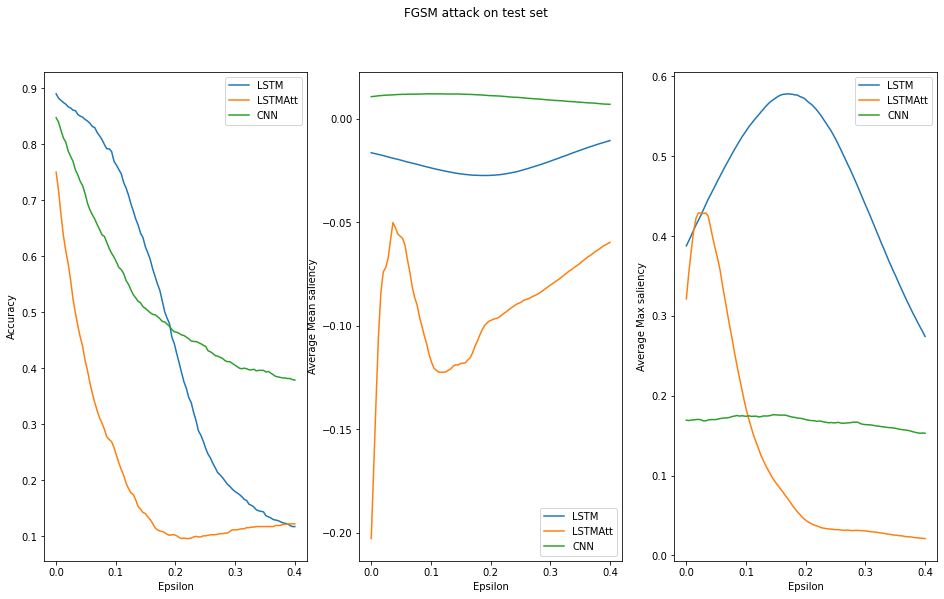

In [31]:
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(16, 9), dpi=72)
plt.suptitle("FGSM attack on test set")

for (name, acc) in accuracies_dict.items():
    ax[0].plot(epsilons, acc, c=colors[name], label=name)
    ax[1].plot(epsilons, saliency_dict[name].mean(axis=-1).mean(axis=-1), label=name)
    ax[2].plot(epsilons, saliency_dict[name].max(axis=-1).mean(axis=-1), label=name)

ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("Average Mean saliency")
ax[2].set_ylabel("Average Max saliency")

for ax_ in ax:
    ax_.set_xlabel("Epsilon")
    ax_.legend()

plt.show()

In [32]:
interact(plot_saliency_eps, 
         model=["LSTM", "LSTMAtt", "CNN"],
         idx=(0, len(labels_test), 1),
         epsilons=fixed(epsilons),
         saliency_dict=fixed(saliency_dict), 
         predicted_label_dict=fixed(predicted_label_dict),
         true_labels=fixed(labels_test))

interactive(children=(Dropdown(description='model', options=('LSTM', 'LSTMAtt', 'CNN'), value='LSTM'), IntSlid…

<function src.plotting.plot_saliency_eps(model, idx, epsilons, saliency_dict, predicted_label_dict, true_labels)>

We see that with increase of the attack intensity saliency gradually drops for some of the test examples.

In [33]:
#saliency_dict["CNN"].shape

(100, 1029, 24)